### Imports

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Functions and Classes

In [2]:
def get_data(directory):
    df = pd.read_csv(directory)
    return df.values


class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs1_buf = np.zeros([size,obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size,obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros(size, dtype=np.uint8)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.uint8)
        self.ptr, self.size, self.max_size = 0, 0, size
    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return dict(
            s = self.obs1_buf[idxs],
            s2= self.obs2_buf[idxs],
            a = self.acts_buf[idxs],
            r = self.rews_buf[idxs],
            d = self.done_buf[idxs],
        )

def get_scaler(env):
    
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        

class MLP(nn.Module):
    def __init__(self, n_inputs, n_actions, n_hidden_layers=1, hidden_dim=32):
        super(MLP, self).__init__()
        
        M = n_inputs
        self.layers = []

        for _ in range(n_hidden_layers):
            layer = nn.Linear(M, hidden_dim)
            M = hidden_dim
            self.layers.append(layer)
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(M, n_actions))
        self.layers = nn.Sequential(*self.layers)
        
    def forward(self, X):
        return self.layers(X)
    
    def save_weights(self, path):
        torch.save(self.state_dict(), path)
        
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))
        
    
def predict(model, np_states):
    with torch.no_grad():
        inputs = torch.from_numpy(np_states.astype(np.float32))
        output = model(inputs)
        
        return output.numpy()
    
def train_one_step(model, criterion, optimizer, inputs, targets):
    inputs  = torch.from_numpy(inputs.astype(np.float32))
    targets = torch.from_numpy(targets.astype(np.float32))
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    loss.backward()
    optimizer.step()

In [3]:
class MultiStockEnv:
    """
    size: 2*n + 1
    
    0 : sell
    1 : hold
    2 : buy
    """
    def __init__(self, data, initial_investment=20000):
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
 
        self.action_space = np.arange(3**self.n_stock)

        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        self.state_dim = self.n_stock * 2 + 1
        
        self.reset()

    
    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()
    
    
    def step(self, action):
        assert action in self.action_space
        
        prev_val = self._get_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        
        self._trade(action)
        
        cur_val = self._get_val()
        
        reward = cur_val - prev_val

        done = self.cur_step == self.n_step - 1

        info = {"cur_val": cur_val}

        return self._get_obs(), reward, done, info
    


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock: 2 * self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        
        return obs
        
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand
    
    def _trade(self, action):
        
        action_vec = self.action_list[action]
        
        sell_index = []
        buy_index = []
        for i, a in enumerate(action_vec):
            if a==0:
                sell_index.append(i)
            elif a==2:
                buy_index.append(i)
                
        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
                
        if buy_index:
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1
                        self.cash_in_hand -= self.stock_price[i]  
                    else:
                        can_buy = False

In [33]:
class DQAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=500)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = MLP(state_size, action_size)
        
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())
        
    def update_replay_memory(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = predict(self.model, state)
        
        return np.argmax(act_values[0])
    
    def replay(self, batch_size=32):
        if self.memory.size < batch_size:
            return
        
        minibatch = self.memory.sample_batch(batch_size)
        states      = minibatch["s"]
        actions     = minibatch["a"]
        rewards     = minibatch["r"]
        next_states = minibatch["s2"]
        done        = minibatch["d"]
        
        target = rewards + (1-done) * self.gamma * np.amax(predict(self.model, next_states), axis=1)
        
        target_full = predict(self.model, states)
        target_full[np.arange(batch_size), actions] = target
        
        train_one_step(self.model, self.criterion, self.optimizer, states, target_full)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def load(self, path):
        self.model.load_weights(path)
        
    def save(self, path):
        self.model.save_weights(path)
        
def play_one_episode(agent, env, is_train,scaler):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        
        if is_train == "train":
            agent.update_replay_memory(state, action, reward, next_state, done)
            agent.replay(batch_size)
    return info["cur_val"]

In [5]:
def split_data(data):
    n_timesteps, n_stocks = data.shape
    n_train = n_timesteps // 2

    train_data = data[:n_train]
    test_data = data[n_train:]
    
    return n_timesteps, n_stocks, n_train, train_data, test_data

In [6]:
def plot_rewards(rewards,mode):
    print(f"average reward: {rewards.mean():.2f}, min: {rewards.min():.2f}, max: {rewards.max():.2f}")
    plt.hist(rewards, bins=20)
    plt.title(mode)
    plt.show

In [34]:
def run(mode,models_folder,train_data,test_data,rewards_folder,initial_investment,num_episodes):
    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQAgent(state_size, action_size)

    scaler = get_scaler(env)
    portfolio_value = []
    
    if mode == "test":
        with open(f"{models_folder}/scaler.pkl", "rb") as f:
            scaler = pickle.load(f)
            
        env = MultiStockEnv(test_data, initial_investment)
        agent.epsilon = 0.01
        
        agent.load(f"{models_folder}/dqn.h5")

    for e in range(num_episodes):
        t0 = datetime.now()
        val = play_one_episode(agent, env, mode, scaler)
        dt = datetime.now() - t0
        if e%10==0:
            print(f"episode: {e+1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
        portfolio_value.append(val)

    if mode == "train":
        agent.save(f"{models_folder}/dqn.h5")
        with open(f"{models_folder}/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)

    np.save(f"{rewards_folder}/{mode}.npy", portfolio_value)

### Config

In [35]:
models_folder = "rl_trader_models"
rewards_folder = "rl_trader_rewards"
num_episodes = 2000
batch_size = 32
initial_investment = 20000

In [36]:
maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)

In [37]:
data = get_data("aapl_msi_sbux.csv")

In [38]:
data.shape

(1259, 3)

In [39]:
n_timesteps, n_stocks, n_train, train_data, test_data = split_data(data)

In [40]:
mode = "train"

In [41]:
run(mode,models_folder,train_data,test_data,rewards_folder,initial_investment,num_episodes)

episode: 1/2000, episode end value: 26559.49, duration: 0:00:01.184012
episode: 11/2000, episode end value: 30939.31, duration: 0:00:00.935276
episode: 21/2000, episode end value: 26925.77, duration: 0:00:00.913739
episode: 31/2000, episode end value: 31602.68, duration: 0:00:00.915908
episode: 41/2000, episode end value: 34342.17, duration: 0:00:00.904373
episode: 51/2000, episode end value: 31941.66, duration: 0:00:00.921866
episode: 61/2000, episode end value: 21670.89, duration: 0:00:00.882353
episode: 71/2000, episode end value: 30715.77, duration: 0:00:00.915983
episode: 81/2000, episode end value: 27878.50, duration: 0:00:00.910895
episode: 91/2000, episode end value: 24567.85, duration: 0:00:00.910508
episode: 101/2000, episode end value: 33434.70, duration: 0:00:00.905846
episode: 111/2000, episode end value: 33136.53, duration: 0:00:00.907909
episode: 121/2000, episode end value: 32388.46, duration: 0:00:00.904348
episode: 131/2000, episode end value: 40740.56, duration: 0:00

average reward: 32781.04, min: 16470.89, max: 62492.77


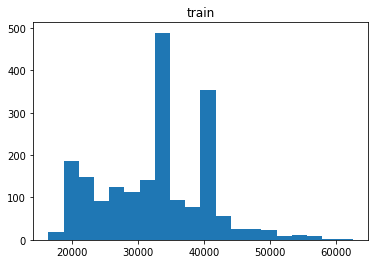

In [42]:
rewards = np.load(f"{rewards_folder}/{mode}.npy")
plot_rewards(rewards,mode)

In [43]:
mode = "test"
run(mode,models_folder,train_data,test_data,rewards_folder,initial_investment,num_episodes)

episode: 1/2000, episode end value: 27555.43, duration: 0:00:00.173778
episode: 11/2000, episode end value: 20196.10, duration: 0:00:00.159237
episode: 21/2000, episode end value: 29476.74, duration: 0:00:00.161936
episode: 31/2000, episode end value: 21650.86, duration: 0:00:00.162027
episode: 41/2000, episode end value: 27410.80, duration: 0:00:00.157905
episode: 51/2000, episode end value: 23611.73, duration: 0:00:00.160798
episode: 61/2000, episode end value: 21673.97, duration: 0:00:00.157829
episode: 71/2000, episode end value: 19044.31, duration: 0:00:00.161642
episode: 81/2000, episode end value: 23659.11, duration: 0:00:00.164928
episode: 91/2000, episode end value: 19879.12, duration: 0:00:00.174832
episode: 101/2000, episode end value: 27877.30, duration: 0:00:00.158339
episode: 111/2000, episode end value: 22153.07, duration: 0:00:00.170627
episode: 121/2000, episode end value: 24206.75, duration: 0:00:00.156130
episode: 131/2000, episode end value: 23217.18, duration: 0:00

average reward: 22626.99, min: 16319.73, max: 35623.63


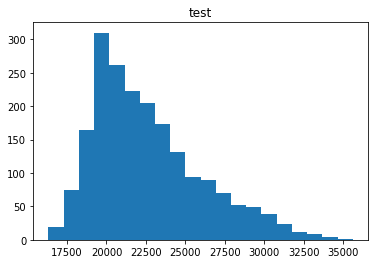

In [44]:
rewards = np.load(f"{rewards_folder}/{mode}.npy")
plot_rewards(rewards,mode)